<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 
</p>    
<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.


**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*

 
    
<p>
La requête SQL suivante a permis de récupérer :

* les données du jeux d'entrainement:     

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id<200000 and PostTypeId=1;``
    

* les données du jeux de test :

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id>=200000 and Id<300000 and PostTypeId=1;``
    
</p>
<p>



In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import p6_util
import p6_util_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font color='blus'>1. Paramaters</font>

In [2]:
#-------------------------------------------------------------------------------
# Apply or not stemming process over sentences
#-------------------------------------------------------------------------------
is_stemming=False

## <font color='blus'>2.Tags analysis</font>

In [4]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

In [5]:
df_sof_tags.shape, df_sof_tags.columns

((50000, 2), Index(['TagName', 'Count'], dtype='object'))

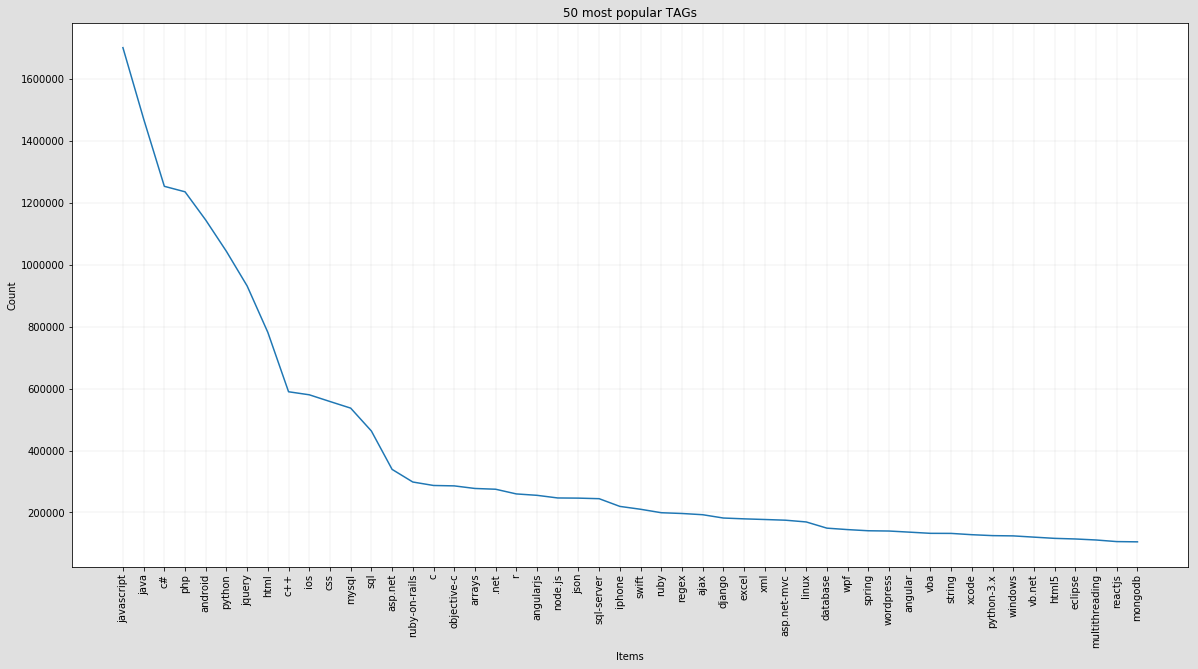

In [6]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular TAGs"
p6_util_plot.ser_item_occurency_plot(df_sof_tags.TagName,df_sof_tags.Count,item_count, title)

---------------------------Count----------------------------
Moyenne: 948.7015
Mediane: 35.0
Modes: 0    1
dtype: int64
Variance: 311074324.89710766
Ecart:17637.299251787605


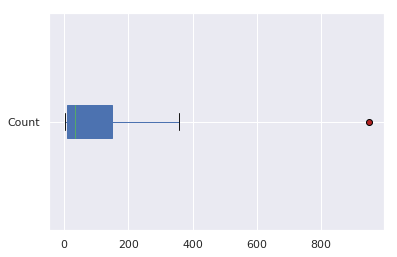

In [9]:
import p5_util_plot
import p3_util_plot
p3_util_plot.df_boxplot_list_display(df_sof_tags, ['Count'], show_outliers=False )


<Figure size 432x288 with 0 Axes>

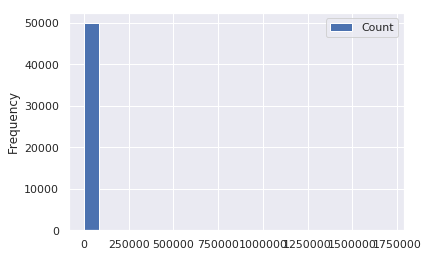

In [10]:
import matplotlib.pyplot as plt

plt.figure();
df_sof_tags.plot.hist(stacked=True, bins=20)

# <font color='blus'>2. Data acquisition</font>

In [11]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)

In [12]:
print(df_sof_train.columns)

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')


# <font color='blus'>3. Train data-set processing</font>

**Merge Body and Title columns**

``Title`` elements are regarded as synthetisis of ``Body`` elements.

Merging ``Title`` with ``Body`` enreach ``Body`` contents with more relevant informations.

In [13]:
df_sof_train['Body']=df_sof_train['Body']+df_sof_train['Title']

**Dataset processing**

Expressions between markers ``code`` and ``/code`` are all removed.

Such expressions are computer language specifics, different as english language. It is considered as having  no semantic value for english language.

In [14]:
df_sof_train.columns

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')

In [15]:
import p6_util
ser_sof_train = p6_util.p6_df_standardization(df_sof_train.Body)


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Filtering alpha-numeric words from sentences...

Removing stopwords...

Lemmatization ...


In [16]:
import p5_util
file_name='./data/ser_sof_train.dump'
p5_util.object_dump(ser_sof_train, file_name)

# <font color='blus'>4. Data analysis</font>

**Cleaned dataset is loaded from dumped file**

In [17]:
import p5_util
file_name='./data/ser_sof_train.dump'
ser_sof_train = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/ser_sof_train.dump


## 4.1 Words frequencies computation

Series ``ser_sof_train`` is converted into a dictionary in order to feed ``compute_frequency_sentence`` function.

In [18]:
ser_sof_train[0]

'track bar form opacity code control work code fine past vb net project convert decimal'

In [19]:
import p6_util
dict_body_train = ser_sof_train.to_dict()
freq_body_train = p6_util.compute_frequency_sentence(dict_body_train, token_mode='nltk')

Transform freq_body_train into a dataframe in order to feed function `p6_util_plot.ser_item_occurency_plot`.

**dictionary is ordered and converted as dataframe.**

In [20]:
import pandas as pd

dict_word = dict()
dict_count = dict()
index =0
for tuple_item in freq_body_train.items():
    dict_word[index] = tuple_item[0]
    dict_count[index] = tuple_item[1]
    index += 1

df_word = pd.DataFrame.from_dict( dict_word, orient='index')
df_count = pd.DataFrame.from_dict( dict_count, orient='index')

df_word_count = pd.DataFrame({'Name':df_word[0],"Count":df_count[0]})


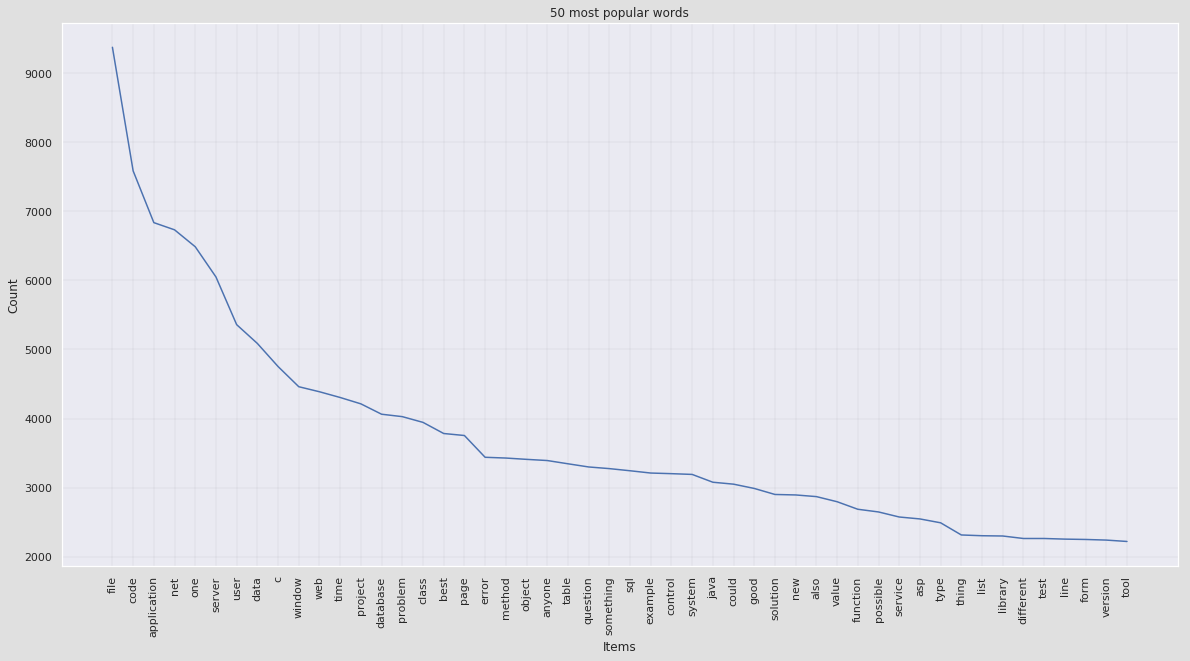

In [21]:
import p6_util_plot

item_count=50
title = str(item_count)+" most popular words"
p6_util_plot.ser_item_occurency_plot(df_word_count.Name,df_word_count.Count,item_count, title)

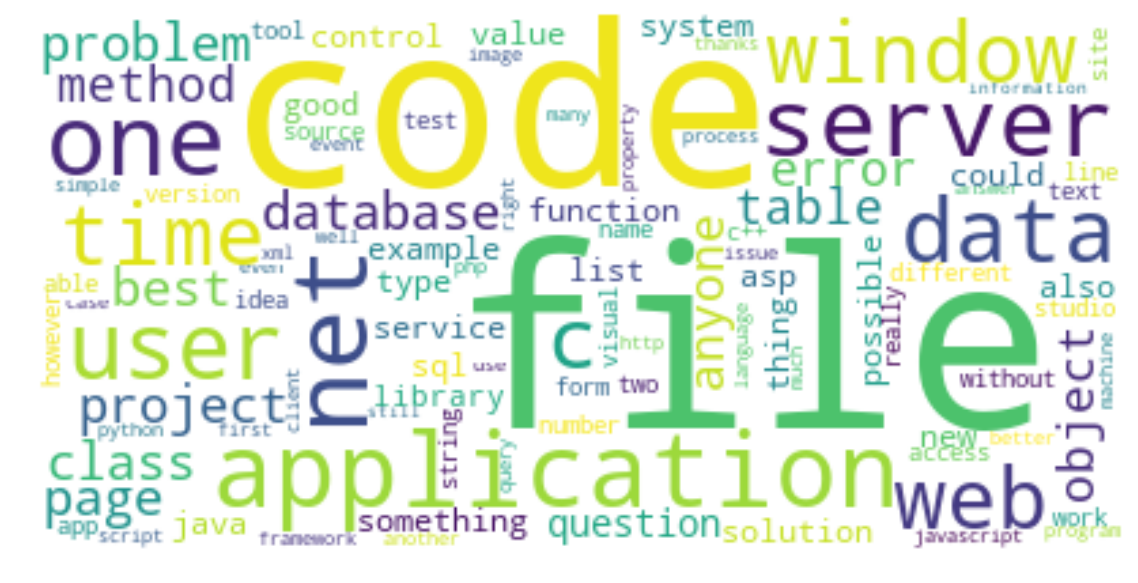

In [28]:
import p6_util_plot
p6_util_plot.display_word_cloud(freq_body_train)

<Figure size 720x720 with 0 Axes>

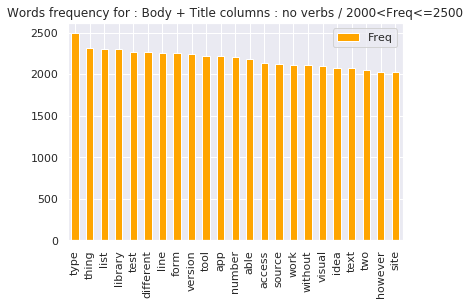

In [29]:
#from wordcloud import WordCloud, STOPWORDS 
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2000<Freq<=2500")

<Figure size 720x720 with 0 Axes>

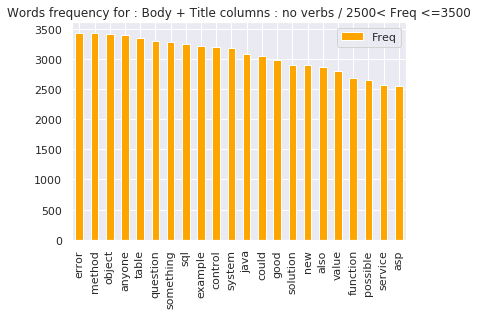

In [30]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2500< Freq <=3500")

<Figure size 720x720 with 0 Axes>

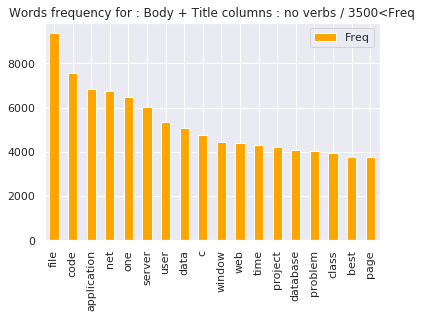

In [31]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="3500<Freq")